In [ ]:
pip install marimo

In [ ]:
import marimo as mo
import os
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import warnings
from matplotlib import animation
import matplotlib.pyplot as plt

np.seterr(divide="ignore", invalid="ignore")
warnings.simplefilter("ignore", RuntimeWarning)
warnings.filterwarnings("ignore")

## A Brief Introduction to t-SNE

_t-distributed stochastic neighbor embedding_ (t-SNE) is a dimensionality reduction tool that is primarily used in datasets with a large dimensional feature space and enables one to visualize the data down, or project it, into a lower dimensional space (usually 2-D). It is especially useful for visualizing non-linearly separable data wherein linear methods such as [Principal Component Analysis](https://en.m.wikipedia.org/wiki/Principal_component_analysis) (PCA) would fail.

Let’s start with breaking down the name _t-distributed stochastic neighbor embedding_ into its components. t-SNE is an extension on stochastic neighbor embedding (SNE) presented 6 years earlier in this [paper](https://cs.nyu.edu/~roweis/papers/sne_final.pdf) by Geoffrey Hinton & Sam Roweis. So let’s start there. The _stochastic_ part of the name comes from the fact that the objective function is not convex and thus different results can arise from different initializations. The _neighbor embedding_ highlights the nature of the algorithm — optimally mapping the points in the original high-dimensional space into the corresponding low-dimensional space while best preserving the “neighborhood” structure of the points. SNE is comprised of the following (simplified) steps:

1. _Obtain the Similarity Matrix between Points in the Original Space_: Compute the conditional probabilities for each datapoint $j$ relative to each datapoint $i$. These conditional probabilities are calculated in the original high-dimensional space using a Gaussian centered at $i$ and take on the following interpretation: the probability that i would pick $j$ as its neighbor in the original space. This creates a matrix that represents similarities between the points.

2. _Initialization_: Choose random starting points in the lower-dimensional space (say, 2-D) for each datapoint in the original space and compute new conditional probabilities similarly as above in this new space.

3. _Mapping_: Iteratively improve upon the points in the lower-dimensional space until the [Kullback-Leibler divergences](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between all the conditional probabilities is minimized. Essentially we are minimizing the differences in the probabilities between the similarity matrices of the two spaces so as to ensure the similarities are best preserved in the mapping of the original high-dimensional dataset to the low-dimensional dataset.

t-SNE improves upon SNE in two primary ways:

1. It minimizes the Kullback-Leibler divergences between the joint probabilities rather than the conditional probabilities. The authors refer to this as “symmetric SNE” b/c their approach ensures that the joint probabilities $p_{ij}$ = $p_{ji}$. **This results in a much better behaved cost function that is easier to optimize.**

2. It computes the similarities between points using a [student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) w/ one degree of freedom (also a [Cauchy Distribution](https://en.wikipedia.org/wiki/Cauchy_distribution)) rather than a Gaussian in the low-dimensional space (step 2 above). Here we can see where the “t” in t-SNE is coming from. **This improvement helps to alleviate the “crowding problem” highlighted by the authors and to further improve the optimization problem.** This “crowding problem” can be envisioned as such: Imagine we have a 10-D space, the amount of space available in 2-D will not be sufficient to accurately capture those moderately dissimilar points compared to the amount of space for nearby points relative to the amount of space available in a 10-D space. More simply, just envision taking a 3-D space and projecting it down to 2-D, the 3-D space will have much more overall space to model the similarities relative to the projection down into 2-D. The Student-t distribution helps alleviate this problem by having heavier tails than the normal distribution. See the [original paper](https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) for a much more in-depth treatment of this problem.

The main takeaway is this: **t-SNE models similarities between datapoints in the high-dimensional space using joint probabilities of “datapoints choosing others as its neighbor”, and then tries to find the best mapping of these points down into the low-dimensional space, while best preserving the original high-dimensional similarities.**

## Implementation from Scratch

Let’s now move on to understanding t-SNE via implementing the original version of the algorithm as presented in the [paper](https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) by Laurens van der Maaten & Geoffrey Hinton. We will first start with implementing algorithm 1 below step-by-step, which will cover 95% of the main algorithm. There are two additional enhancements the authors note: 1) Early Exaggeration & 2) Adaptive Learning Rates. We will only discuss adding in the early exaggeration as that is most conducive in aiding the interpretation of the actual algorithms inner workings, as the adaptive learning rate is focused on improving the rates of convergence.


In [ ]:
mo.image("./tsne.png",width="1000px").center()

Html()

### 1. Inputs

Following the original paper, we will be using the publicly available [MNIST dataset](https://www.openml.org/search?type=data&status=active&id=554&sort=runs) from OpenML with images of handwritten digits from 0–9.[2] We will also randomly sample 1000 images from the dataset & reduce the dimensionality of the dataset using Principal Component Analysis (PCA) and keep 30 components. These are both to improve computational time of the algorithm, as the code here is not optimized for speed, but rather for interpretability & learning.

In [ ]:
# Fetch MNIST data
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_total = pd.DataFrame(mnist["data"])
y_total = pd.DataFrame(mnist["target"])

X_reduced = X_total.sample(n=1000)
y_reduced = y_total.loc[X_reduced.index]

# PCA to keep 30 components
X = PCA(n_components=30).fit_transform(X_reduced)

This will be our X dataset with each row being an image and each column being a feature, or principal component in this case (i.e. linear combinations of the original pixels):

In [ ]:
# To make it look pretty in marimo
df_X = pd.DataFrame(X)
df_X.columns = df_X.columns.astype(str)
df_X

0           1           2            3           4           5  \
0    -418.350616  676.034963 -548.460920   170.565975  142.145281 -430.912186   
1    -869.727929  740.422840 -357.641103   -35.256162  -49.354513  -93.323623   
2     -67.776443 -745.361505  462.299475    62.010165  117.671837  190.959912   
3    -747.455479  170.081900  166.968123    80.464359 -543.459686  218.003520   
4    1051.496013  690.789616 -435.892399 -1261.657230  447.599473   68.444351   
..           ...         ...         ...          ...         ...         ...   
995   658.952573  243.962898  826.199557   363.915914 -124.315065 -134.621934   
996  -835.126288  233.793745  -61.293918  -375.209746 -715.447536  111.520235   
997    24.192265 -782.129632  499.771651   250.260876  -37.173564  198.633777   
998  -454.776352 -796.719795 -418.313793   438.280226  190.161856 -764.553707   
999  -614.675020 -723.383103  315.377434   190.965269 -193.148786 -106.156686   

              6           7           8           9  ...          20  \
0    -90.269991 -122.269054 -193.298531  -27.010900  ... -126.214517   
1    445.979200 -375.369638  399.504801 -154.833830  ...   10.077800   
2   -192.755739   68.684911   33.874139  396.312528  ...  -74.862037   
3    473.942563 -320.501340  -19.886620  466.317153  ... -193.341300   
4    314.797318  233.483538 -383.091210  138.178484  ...  -13.147066   
..          ...         ...         ...         ...  ...         ...   
995 -569.803617   -2.385720 -144.130195   48.991423  ...   49.140458   
996    9.298863 -105.716837 -256.481935  -50.597595  ...  -80.267070   
997 -379.177564  111.794003  516.280294  297.895896  ...   15.084597   
998  561.009820   88.012918  146.595164 -409.927446  ...   61.490253   
999  538.565449  372.635490 -102.826023  276.379612  ...  239.969387   

             21          22          23          24          25          26  \
0    -60.934540  290.156441  176.181514  -35.715647  -38.725412  -23.527445   
1     -5.420226   26.684188   16.201931   19.294070  -48.322081  -55.712299   
2     33.626385 -177.744588   62.490025 -328.223895   42.026944   58.063229   
3     61.766379    2.344349 -324.364735 -190.590817  -99.289348  -13.694649   
4    140.177692  -71.728128  268.553246  189.493566  -14.997270   83.906199   
..          ...         ...         ...         ...         ...         ...   
995 -277.097959  145.591107   41.398868 -161.522646  437.901893 -301.110672   
996  179.099234   94.086125   -7.174121  -47.793421  134.710852  -82.297741   
997  273.802354  -19.576143 -136.085170 -184.459828   99.585012  160.637807   
998   32.387781   68.201776   94.354605  205.940619   84.351684  -28.755923   
999  -59.097123   -4.127177  -84.468589  -36.353837 -147.047967 -171.429868   

             27          28          29  
0    -85.649194 -349.563484 -331.382411  
1    -76.974594   71.483100  -17.960617  
2      5.555283  -14.024350 -230.578824  
3     76.941141 -197.153947 -113.302346  
4   -126.426303  122.984232  -73.367470  
..          ...         ...         ...  
995  232.040604  -94.173087    4.661354  
996    2.646673  -17.800631 -132.694059  
997  -49.490236 -196.375687 -126.517123  
998 -122.177298   67.317885  201.191850  
999  -74.441471  202.354294   55.049206  

[1000 rows x 30 columns]

We also will need to specify the cost function parameters — perplexity — and the optimization parameters — iterations, learning rate, & momentum. We will hold off on these for now and address them as they appear at each stage.

In terms of output, recall that we seek a the low-dimensional mapping of the original dataset X. We will be mapping the original space into a 2 dimensional space throughout this example. Thus, our new output will be the 1000 images now represented in a 2 dimensional space rather than the original 30 dimensional space, with a shape of [1000, 2].

### 2. Compute Affinities/Similarities of X in the Original Space

Now that we have our inputs, the first step is to compute the pairwise similarities in the original high dimensional space. That is, for each image $i$ we compute the probability that $i$ would pick image $j$ as its neighbor in the original space for each $j$. These probabilities are calculated via a normal distribution centered around each point and then are normalized to sum up to 1. Mathematically, we have:

$$
\begin{equation}
p_{j|i}=\frac{\exp{(-\|x_i-x_j\|^2/2\sigma_i^2)}}{\sum_{k\ne i}\exp{(-\|x_i-x_j\|^2/2\sigma_i^2)}}
\tag{1}
\end{equation}
$$

Note that, in our case with n = 1000, these computations will result in a 1000 x 1000 matrix of similarity scores. Note we set $p$ = 0 whenever $i$ = $j$ b/c we are modeling pairwise similarities. Then we should find the optimal value for $\sigma$. This value is determined for each observation $i$ via a grid search based on the user-specified desired [perplexity](https://en.wikipedia.org/wiki/Perplexity) of the distributions.

Given a specified value of perplexity (which in this context can be loosely thought about as the number of nearest neighbors for each point), we do a grid search over a range of values of $\sigma$ such that the following equation is as close to equality as possible for each $i$:

$$
\begin{equation}
Perp(P_i)=2^{H(P_i)}
\tag{2}
\end{equation}
$$

where $H(P_i)$ is the Shannon entropy of $P$:

$$
\begin{equation}
H(P_i) = - \sum_jp_{j|i}\log_2p_{j|i}
\tag{2}
\end{equation}
$$

In our case, we will set perplexity = 10 and set the search space to be defined by [0.01 * standard deviation of the norms for the difference between images $i$ and $j$, 5 * standard deviation of the norms for the difference between images $i$ and $j$] divided into 200 equal steps.

In [ ]:
def grid_search(diff_i: np.ndarray, i: int, perplexity: int) -> float:
    """
    Helper function to obtain sigma's based on user-specified perplexity.

    Parameters
    -----------
    diff_i
        Array containing the pairwise differences between data points.
    i
        Index of the current data point.
    perplexity
        User-specified perplexity value.

    Returns
    -------
    float
        The value of sigma that satisfies the perplexity condition.
    """

    result = np.inf  # Set first result to be infinity

    norm = np.linalg.norm(diff_i, axis=1)
    std_norm = np.std(norm)  # Use standard deviation of norms to define search space

    for sigma_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        # Equation 1 Numerator
        p = np.exp(-(norm**2) / (2 * sigma_search**2))

        # Set p = 0 when i = j
        p[i] = 0

        # Equation 1 (ε -> 0)
        ε = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), ε)

        # Shannon Entropy
        H = -np.sum(p_new * np.log2(p_new))

        # Get log(perplexity equation) as close to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            sigma = sigma_search

    return sigma

### <span style="color:orange">TODO</span>
Now here you should complete this function to compute the pairwise affinities. You are provided with a loop that in its $i$-th iteration the conditional probability of $p_{j|i}$ for all the values of $j$ have to be computed using the equation 1. (Don't forget to set $p_{ii}=0$)

In [ ]:
def Hbeta(D: np.ndarray, beta: float = 1.0):

    P = np.exp(-D * beta)
    P[0] = 0  # ensure p_ii = 0
    sumP = np.sum(P)
    if sumP == 0:
        return np.zeros_like(D), 0.0
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    return P / sumP, H

def binary_searc(D: np.ndarray, target_perplexity: float, tol: float = 1e-5, max_iter: int = 50):

    beta = 1.0
    betamin = -np.inf
    betamax = np.inf
    logU = np.log(target_perplexity)

    for _ in range(max_iter):
        P, H = Hbeta(D, beta)
        Hdiff = H - logU

        if np.abs(Hdiff) < tol:
            break

        if Hdiff > 0:
            betamin = beta
            beta = (beta * 2) if betamax == np.inf else (beta + betamax) / 2
        else:
            betamax = beta
            beta = (beta / 2) if betamin == -np.inf else (beta + betamin) / 2

    return P

def get_original_pairwise_affinities(X: np.ndarray, perplexity: int = 10) -> np.ndarray:
    """
    Function to obtain affinities matrix.

    Parameters
    ----------
    X
        The input data array.
    perplexity
        The perplexity value for the grid search.

    Returns
    ------
    np.ndarray
        The pairwise affinities matrix.
    """


    n = len(X)
    print("Computing Pairwise Affinities....")

    p_ij = np.zeros(shape=(n, n))
    for i in range(n):
        distances = np.sum((X[i] - X) ** 2, axis=1)
        distances[i] = 0  # self-distance set to 0 to exclude it
        P = binary_searc(distances, target_perplexity=perplexity)
        p_ij[i, :] = P
        p_ij[i, i] = 0  # explicitly set self-probability to 0

    ε = np.nextafter(0, 1)
    p_ij = np.maximum(p_ij, ε)
    print("Completed Pairwise Affinities Matrix. \n")

    return p_ij



Given these functions, we can compute the affinity matrix via:

In [ ]:
p_ij = get_original_pairwise_affinities(X)

Computing Pairwise Affinities....
Completed Pairwise Affinities Matrix. 



In [ ]:
# To make it look pretty in marimo
df_p_ij = pd.DataFrame(p_ij)
df_p_ij.columns = df_p_ij.columns.astype("str")
df_p_ij

0              1              2              3  \
0    4.940656e-324   1.265818e-03   1.150383e-09   6.178612e-06   
1    4.940656e-324  4.940656e-324   1.355027e-14   8.969587e-07   
2    4.940656e-324   4.671769e-08  4.940656e-324   8.041771e-06   
3    4.940656e-324   2.262974e-08   6.988573e-13  4.940656e-324   
4    4.940656e-324   1.150621e-05   3.581753e-06   2.799491e-06   
..             ...            ...            ...            ...   
995  4.940656e-324   2.157049e-06   2.005676e-04   7.199471e-06   
996  4.940656e-324   4.054655e-07   8.575131e-14   1.791430e-05   
997  4.940656e-324   6.469759e-08   1.499444e-02   7.108584e-06   
998  4.940656e-324   1.574920e-06   1.112496e-07   5.285879e-08   
999  4.940656e-324   2.881169e-08   1.027900e-05   1.246273e-05   

                 4             5             6             7             8  \
0     2.157422e-11  8.376013e-06  5.549981e-08  5.660136e-04  2.635787e-07   
1     3.405483e-19  1.067293e-08  6.626883e-13  1.490629e-08  3.655570e-09   
2     1.742485e-11  6.689926e-06  5.425602e-07  6.729500e-07  2.877807e-05   
3     3.785733e-27  4.008664e-12  5.511547e-15  1.079411e-14  1.185650e-10   
4    4.940656e-324  1.057913e-04  4.978437e-06  7.668599e-06  1.461502e-04   
..             ...           ...           ...           ...           ...   
995   1.147098e-07  6.861888e-06  2.605988e-04  2.836501e-05  5.568412e-06   
996   1.467844e-23  1.665760e-09  1.742233e-15  2.621828e-12  5.417476e-09   
997   2.854245e-12  3.381702e-06  1.674107e-05  1.208221e-07  4.210058e-06   
998   1.012688e-13  5.515339e-08  7.049843e-09  4.548354e-04  6.419865e-06   
999   5.805633e-15  6.720620e-07  3.524069e-09  3.432979e-06  9.221267e-04   

                9  ...           990           991           992  \
0    1.646604e-08  ...  2.225121e-09  2.596401e-07  3.122748e-08   
1    3.644962e-10  ...  7.529725e-15  3.676389e-09  8.835553e-12   
2    5.587164e-07  ...  8.179960e-04  1.450279e-05  1.562197e-06   
3    1.367894e-11  ...  4.229903e-14  6.274312e-04  9.071404e-15   
4    3.111994e-06  ...  9.832708e-07  1.516310e-06  1.578714e-05   
..            ...  ...           ...           ...           ...   
995  4.766016e-07  ...  8.611116e-05  1.736481e-05  3.840493e-05   
996  1.131819e-12  ...  4.209824e-16  2.501440e-07  5.881456e-16   
997  1.771147e-05  ...  1.559226e-03  4.979828e-06  7.864625e-06   
998  1.393284e-07  ...  4.957336e-05  4.589489e-07  6.608165e-10   
999  7.522089e-08  ...  6.985565e-05  2.120251e-03  7.629679e-10   

              993           994            995            996            997  \
0    2.837298e-13  5.384410e-10   1.688990e-09   3.020566e-04   7.771402e-11   
1    1.037594e-20  2.270720e-11   1.564093e-16   1.058535e-05   9.699432e-16   
2    5.018587e-10  7.895808e-08   3.751940e-06   4.224505e-06   1.072513e-02   
3    4.021427e-23  2.584840e-17   6.938513e-19   2.143154e-05   2.924706e-14   
4    7.434924e-05  1.557680e-05   6.523152e-06   1.848619e-05   3.591950e-07   
..            ...           ...            ...            ...            ...   
995  1.594074e-05  9.879517e-05  4.940656e-324   1.982970e-05   1.630461e-04   
996  1.363885e-22  2.796382e-19   1.321016e-17  4.940656e-324   4.946043e-15   
997  7.645375e-09  2.632335e-07   8.810151e-06   4.574873e-06  4.940656e-324   
998  3.079760e-12  3.565273e-09   8.978910e-11   3.284981e-07   1.565556e-07   
999  5.405680e-13  1.409188e-09   2.565648e-10   4.577667e-06   4.103236e-07   

               998            999  
0     5.340879e-07   1.296192e-08  
1     8.243328e-11   2.419284e-12  
2     3.632333e-07   8.454485e-05  
3     6.877861e-17   3.082228e-10  
4     7.180046e-07   1.360934e-06  
..             ...            ...  
995   4.389217e-07   4.863042e-06  
996   2.513168e-15   2.775154e-11  
997   1.900348e-06   1.808579e-05  
998  4.940656e-324   2.168676e-04  
999   8.574950e-05  4.940656e-324  

[1000 rows x 1000 columns]

Note, the diagonal elements are set to $\epsilon \approx 0$ by construction (whenever $i$ = $j$). Recall that a key extension of the t-SNE algorithm is to compute the joint probabilities rather than the conditional probabilities. This is computed simply as follow:

$$
\begin{equation}
p_{ij}=\frac{p_{j|i}+p_{i|j}}{2n}
\tag{3}
\end{equation}
$$

### <span style="color:orange">TODO</span>

Complete the the following function to make the probabilities symmetric.

In [ ]:
def get_symmetric_p_ij(p_ij: np.ndarray) -> np.ndarray:
    """
    Function to obtain symmetric affinities matrix utilized in t-SNE.

    Parameters
    ----------
    p_ij : np.ndarray
        The input affinity matrix.

    Returns
    -------
    np.ndarray
        The symmetric affinities matrix.
    """
    print("Computing Symmetric p_ij matrix....")

    n = p_ij.shape[0]
    p_ij_symmetric = (p_ij + p_ij.T) / (2 * n)

    # To ensure numerical stability (no zeros)
    p_ij_symmetric = np.maximum(p_ij_symmetric, np.nextafter(0, 1))

    print("Completed Symmetric p_ij Matrix. \n")
    return p_ij_symmetric


Feeding in `p_ij` from above, we obtain the following symmetric affinities matrix:

In [ ]:
p_ij_symmetric = get_symmetric_p_ij(p_ij)

Computing Symmetric p_ij matrix....
Completed Symmetric p_ij Matrix. 



In [ ]:
# To make it look pretty in marimo
df_p_ij_symmetric = pd.DataFrame(p_ij_symmetric)
df_p_ij_symmetric.columns = df_p_ij_symmetric.columns.astype("str")
df_p_ij_symmetric

0              1              2              3  \
0    4.940656e-324   6.329090e-07   5.751917e-13   3.089306e-09   
1     6.329090e-07  4.940656e-324   2.335885e-11   4.597942e-10   
2     5.751917e-13   2.335885e-11  4.940656e-324   4.020886e-09   
3     3.089306e-09   4.597942e-10   4.020886e-09  4.940656e-324   
4     1.078711e-14   5.753104e-09   1.790885e-09   1.399746e-09   
..             ...            ...            ...            ...   
995   8.444950e-13   1.078524e-09   1.021597e-07   3.599736e-09   
996   1.510283e-07   5.495410e-09   2.112252e-09   1.967292e-08   
997   3.885701e-14   3.234880e-11   1.285978e-05   3.554292e-09   
998   2.670440e-10   7.875014e-10   2.372414e-10   2.642939e-11   
999   6.480962e-12   1.440705e-11   4.741192e-08   6.231520e-09   

                 4             5             6             7             8  \
0     1.078711e-14  4.188007e-09  2.774990e-11  2.830068e-07  1.317894e-10   
1     5.753104e-09  1.996741e-08  8.114964e-09  6.136988e-08  2.194482e-08   
2     1.790885e-09  5.501085e-09  1.128290e-08  1.196235e-09  3.383543e-08   
3     1.399746e-09  5.510109e-09  1.841839e-08  1.739239e-09  4.407907e-08   
4    4.940656e-324  5.289971e-08  2.498189e-09  3.834503e-09  7.309978e-08   
..             ...           ...           ...           ...           ...   
995   3.318931e-09  3.437498e-09  1.909142e-07  1.447058e-08  2.799378e-09   
996   9.243096e-09  8.448538e-08  1.562599e-08  1.688708e-08  2.330864e-07   
997   1.795989e-10  1.975921e-09  6.977976e-08  9.908495e-11  2.998586e-09   
998   3.590024e-10  8.014102e-11  1.205805e-09  9.368115e-07  1.482162e-08   
999   6.804669e-10  3.327211e-09  3.800933e-09  3.457566e-08  2.420755e-06   

                9  ...           990           991           992  \
0    8.233021e-12  ...  1.112561e-12  1.298201e-10  1.561374e-11   
1    3.219990e-07  ...  1.887104e-11  1.532239e-09  1.829654e-08   
2    5.248639e-08  ...  7.840730e-07  7.813940e-09  2.074164e-08   
3    6.216826e-07  ...  1.287512e-09  9.875665e-06  1.782728e-08   
4    1.615136e-09  ...  4.916363e-10  7.581550e-10  7.931521e-09   
..            ...  ...           ...           ...           ...   
995  8.235740e-10  ...  4.360864e-08  8.683621e-09  2.538295e-08   
996  3.675265e-07  ...  2.576685e-10  2.050572e-07  9.341216e-09   
997  2.452319e-07  ...  1.176974e-06  2.523276e-09  3.168569e-08   
998  4.553237e-08  ...  8.057875e-08  2.607971e-10  1.818156e-10   
999  9.961346e-08  ...  2.218968e-07  2.096660e-06  1.223074e-09   

              993           994            995            996            997  \
0    1.418649e-16  2.692205e-13   8.444950e-13   1.510283e-07   3.885701e-14   
1    8.059018e-10  8.343689e-08   1.078524e-09   5.495410e-09   3.234880e-11   
2    3.593995e-09  9.113455e-09   1.021597e-07   2.112252e-09   1.285978e-05   
3    3.527037e-09  1.195388e-08   3.599736e-09   1.967292e-08   3.554292e-09   
4    5.241048e-08  8.035507e-09   3.318931e-09   9.243096e-09   1.795989e-10   
..            ...           ...            ...            ...            ...   
995  6.245913e-08  1.073919e-07  4.940656e-324   9.914848e-09   8.592814e-08   
996  5.604799e-09  4.304928e-09   9.914848e-09  4.940656e-324   2.287436e-09   
997  5.423436e-09  7.351757e-09   8.592814e-08   2.287436e-09  4.940656e-324   
998  6.129522e-10  2.891849e-09   2.195058e-10   1.642491e-10   1.028452e-09   
999  1.535091e-09  7.604328e-09   2.431649e-09   2.288847e-09   9.248054e-09   

               998            999  
0     2.670440e-10   6.480962e-12  
1     7.875014e-10   1.440705e-11  
2     2.372414e-10   4.741192e-08  
3     2.642939e-11   6.231520e-09  
4     3.590024e-10   6.804669e-10  
..             ...            ...  
995   2.195058e-10   2.431649e-09  
996   1.642491e-10   2.288847e-09  
997   1.028452e-09   9.248054e-09  
998  4.940656e-324   1.513085e-07  
999   1.513085e-07  4.940656e-324  

[1000 rows x 1000 columns]

### 3. Sample Initial Solution & Compute Low Dimensional Affinity Matrix

Now we should sample a random initial solution in the lower dimensional space.

In [ ]:
def initialization(
    X: np.ndarray, n_dimensions: int = 2
) -> np.ndarray:
    """
    Obtain initial solution for t-SNE randomly.

    Parameters
    ----------
    X
        The input data array.
    n_dimensions
        The number of dimensions for the output solution. Default is 2.

    Returns
    -------
    np.ndarray
        The initial solution for t-SNE.
    """

    # Sample Initial Solution
    y0 = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dimensions))
    return y0

In [ ]:
y0 = initialization(X)

In [ ]:
df_y0 = pd.DataFrame(y0)
df_y0.columns = df_y0.columns.astype("str")
df_y0

0         1
0   -0.000063  0.000176
1    0.000059  0.000178
2    0.000006 -0.000236
3    0.000016  0.000161
4    0.000161  0.000120
..        ...       ...
995 -0.000008  0.000144
996  0.000123 -0.000050
997 -0.000046  0.000202
998 -0.000038  0.000119
999 -0.000023  0.000013

[1000 rows x 2 columns]

Now, we want to compute the affinity matrix in this lower dimensional space. However, recall that we do this utilizing a student's t-distribution w/ 1 degree of freedom:

$$
\begin{equation}
q_{ij}=\frac{(1+\|y_i-y_j\|^2)^{-1}}{\sum_{k \ne l} (1+\|y_i-y_j\|^2)^{-1}}
\tag{4}
\end{equation}
$$

Again, we set $q=0$ whenever $i = j$. Note this equation differs from eq. (1) in that the denominator is over all $i$ and thus symmetric by construction.

### <span style="color:orange">TODO</span>

Here you should compute the joint probability in the lower dimension space. It is similar to what you did for the original datapoints but here you should use the above equation in your calculations.

In [ ]:
def get_low_dimensional_affinities(Y: np.ndarray) -> np.ndarray:
    """
    Obtain low-dimensional affinities.

    Parameters
    -----------
    Y
        The low-dimensional representation of the data points.

    Returns
    -------
    np.ndarray
        The low-dimensional affinities matrix.
    """
    n = len(Y)
    q_ij = np.zeros(shape=(n, n))

    for i in range(0, n):
        for j in range(0, n):
            if i != j:
                dist = np.sum((Y[i] - Y[j]) ** 2)
                q_ij[i, j] = 1 / (1 + dist)

    sum_q = np.sum(q_ij)
    q_ij = q_ij / sum_q

    # Set 0 values to minimum numpy value (using ε approx. = 0 for numerical stability)
    ε = np.nextafter(0, 1)
    q_ij = np.maximum(q_ij, ε)
    return q_ij


Here we are seeking a 1000 x 1000 affinity matrix but now in the lower dimensional space:

In [ ]:
q_ij = get_low_dimensional_affinities(y0)

In [ ]:
# To make it look pretty in marimo
df_q_ij = pd.DataFrame(q_ij)
df_q_ij.columns = df_q_ij.columns.astype("str")
df_q_ij

0              1              2              3  \
0    4.940656e-324   1.001001e-06   1.001001e-06   1.001001e-06   
1     1.001001e-06  4.940656e-324   1.001001e-06   1.001001e-06   
2     1.001001e-06   1.001001e-06  4.940656e-324   1.001001e-06   
3     1.001001e-06   1.001001e-06   1.001001e-06  4.940656e-324   
4     1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06   
..             ...            ...            ...            ...   
995   1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06   
996   1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06   
997   1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06   
998   1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06   
999   1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06   

                 4         5         6         7         8         9  ...  \
0     1.001001e-06  0.000001  0.000001  0.000001  0.000001  0.000001  ...   
1     1.001001e-06  0.000001  0.000001  0.000001  0.000001  0.000001  ...   
2     1.001001e-06  0.000001  0.000001  0.000001  0.000001  0.000001  ...   
3     1.001001e-06  0.000001  0.000001  0.000001  0.000001  0.000001  ...   
4    4.940656e-324  0.000001  0.000001  0.000001  0.000001  0.000001  ...   
..             ...       ...       ...       ...       ...       ...  ...   
995   1.001001e-06  0.000001  0.000001  0.000001  0.000001  0.000001  ...   
996   1.001001e-06  0.000001  0.000001  0.000001  0.000001  0.000001  ...   
997   1.001001e-06  0.000001  0.000001  0.000001  0.000001  0.000001  ...   
998   1.001001e-06  0.000001  0.000001  0.000001  0.000001  0.000001  ...   
999   1.001001e-06  0.000001  0.000001  0.000001  0.000001  0.000001  ...   

          990       991       992       993       994            995  \
0    0.000001  0.000001  0.000001  0.000001  0.000001   1.001001e-06   
1    0.000001  0.000001  0.000001  0.000001  0.000001   1.001001e-06   
2    0.000001  0.000001  0.000001  0.000001  0.000001   1.001001e-06   
3    0.000001  0.000001  0.000001  0.000001  0.000001   1.001001e-06   
4    0.000001  0.000001  0.000001  0.000001  0.000001   1.001001e-06   
..        ...       ...       ...       ...       ...            ...   
995  0.000001  0.000001  0.000001  0.000001  0.000001  4.940656e-324   
996  0.000001  0.000001  0.000001  0.000001  0.000001   1.001001e-06   
997  0.000001  0.000001  0.000001  0.000001  0.000001   1.001001e-06   
998  0.000001  0.000001  0.000001  0.000001  0.000001   1.001001e-06   
999  0.000001  0.000001  0.000001  0.000001  0.000001   1.001001e-06   

               996            997            998            999  
0     1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06  
1     1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06  
2     1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06  
3     1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06  
4     1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06  
..             ...            ...            ...            ...  
995   1.001001e-06   1.001001e-06   1.001001e-06   1.001001e-06  
996  4.940656e-324   1.001001e-06   1.001001e-06   1.001001e-06  
997   1.001001e-06  4.940656e-324   1.001001e-06   1.001001e-06  
998   1.001001e-06   1.001001e-06  4.940656e-324   1.001001e-06  
999   1.001001e-06   1.001001e-06   1.001001e-06  4.940656e-324  

[1000 rows x 1000 columns]

### 4. Compute Gradient of the Cost Function

Recall, our cost function is the Kullback-Leibler divergence between joint probability distributions in the high dimensional space and low dimensional space:

$$
\begin{equation}
C=\text{KL}(P\|Q)=\sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}
\tag{5}
\end{equation}
$$

Intuitively, we want to minimize the difference in the affinity matrices $p_{ij}$ and $q_{ij}$ thereby best preserving the “neighborhood” structure of the original space. The optimization problem is solved using gradient descent, but first let’s look at computing the gradient for the cost function above. The authors derive (see appendix A of the paper) the gradient of the cost function as follows:

$$
\begin{equation}
\frac{\partial C}{\partial y_i} = 4 \sum_j(p_{ij}-q_{ij})(1+\|y_i-y_j\|^2)^{-1}(y_i-y_j)
\tag{6}
\end{equation}
$$

### <span style="color:orange">TODO</span>
Now use the above equations for calculation of gradients.

In [ ]:
def get_gradient(p_ij: np.ndarray, q_ij: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Obtain gradient of cost function at current point Y.

    Parameters
    ----------
    p_ij
        The joint probability distribution matrix.
    q_ij
        The Student's t-distribution matrix.
    Y
        The current point in the low-dimensional space.

    Returns
    ------
    np.ndarray
        The gradient of the cost function at the current point Y.
    """
    n = len(p_ij)

    # Compute gradient
    gradient = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0, n):
        for j in range(0, n):
            if i != j:
                diff = Y[i] - Y[j]
                dist_sq = np.sum(diff ** 2)
                q_factor = (1 + dist_sq)
                grad_component = (p_ij[i, j] - q_ij[i, j]) * diff / q_factor
                gradient[i] += grad_component

        gradient[i] *= 4  # t-SNE uses a factor of 4 in its gradient

    return gradient


Feeding in the relevant arguments, we obtain the gradient as follows:

In [ ]:
gradient = get_gradient(p_ij_symmetric, q_ij, y0)

In [ ]:
# Make pretty in marimo
df_gradient = pd.DataFrame(gradient)
df_gradient.columns = df_gradient.columns.astype("str")
df_gradient

0             1
0    2.908027e-07 -2.218865e-07
1   -1.392734e-07 -3.104688e-07
2   -4.559570e-08  4.553920e-07
3   -2.305288e-08 -2.194173e-07
4   -5.344506e-07 -3.575421e-07
..            ...           ...
995  1.502326e-08 -3.852490e-07
996 -2.660758e-07  5.033543e-08
997  4.878612e-08 -3.787044e-07
998 -5.161124e-08  3.997734e-08
999  2.626751e-08 -3.570744e-08

[1000 rows x 2 columns]

Now, we have all the pieces in order to solve the optimization problem!

### 5. Iterate & Optimize the Low-Dimensional Mapping

In order to update our low-dimensional mapping, we use [gradient descent with momentum](https://en.wikipedia.org/wiki/Gradient_descent) as outlined by the authors:

$$
\begin{equation}
\mathcal{Y}^{(t)}=\mathcal{Y}^{(t-1)}+\eta\frac{\partial C}{\partial \mathcal{Y}} + \alpha(t)(\mathcal{Y}^{(t-1)}-\mathcal{Y}^{(t-2)})
\tag{7}
\end{equation}
$$

where $\eta$ is our [learning rate](https://en.wikipedia.org/wiki/Learning_rate) and $\alpha(t)$ is our momentum term as a function of time. The learning rate controls the step size at each iteration and the momentum term allows the optimization algorithm to gain inertia in the smooth direction of the search space, while not being bogged down by the noisy parts of the gradient. We will set $\eta=200$ for our example and will fix $\alpha(t)=0.5$ if $t < 250$ and $\alpha(t)=0.8$ otherwise. We have all the components necessary above to compute to the update rule, thus we can now run our optimization over a set number of iterations $T$ (we will set $T=1000$).

Before we set up for iteration scheme, let’s first introduce the enhancement the authors refer to as “early exaggeration”. This term is a constant that scales the original matrix of affinities $p_{ij}$. What this does is it places more emphasis on modeling the very similar points (high values in $p_{ij}$ from the original space) in the new space early on and thus forming “clusters” of highly similar points. The early exaggeration is placed on at the beginning of the iteration scheme ($T<250$) and then turned off otherwise. Early exaggeration will be set to 4 in our case. We will see this in action in our visual below following implementation.

Now, putting all of the pieces together for the algorithm, we have the following:

In [ ]:
def tsne(
    X: np.ndarray,
    perplexity: int = 10,
    T: int = 1000,
    η: int = 200,
    early_exaggeration: int = 4,
    n_dimensions: int = 2,
) -> list[np.ndarray, np.ndarray]:
    """
    t-SNE (t-Distributed Stochastic Neighbor Embedding) algorithm implementation.

    Parameters
    ----------
    X
        The input data matrix of shape (n_samples, n_features).
    perplexity
        The perplexity parameter. Default is 10.
    T
        The number of iterations for optimization. Default is 1000.
    η
        The learning rate for updating the low-dimensional embeddings. Default is 200.
    early_exaggeration
        The factor by which the pairwise affinities are exaggerated during the early iterations of optimization.
        Default is 4.
    n_dimensions
        The number of dimensions of the low-dimensional embeddings.
        Default is 2.

    Returns
    -------
    list[np.ndarray, np.ndarray]
        A list containing the final low-dimensional embeddings and the history of embeddings at each iteration.
    """
    n = len(X)

    # Get original affinities matrix
    p_ij = get_original_pairwise_affinities(X, perplexity)
    p_ij_symmetric = get_symmetric_p_ij(p_ij)

    # Initialization
    Y = np.zeros(shape=(T, n, n_dimensions))
    Y_minus1 = np.zeros(shape=(n, n_dimensions))
    Y[0] = Y_minus1
    Y1 = initialization(X, n_dimensions)
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization
    for t in range(1, T - 1):
        # Momentum & Early Exaggeration
        if t < 250:
            α = 0.5
            early_exaggeration = early_exaggeration
        else:
            α = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        q_ij = get_low_dimensional_affinities(Y[t])

        # Get Gradient of Cost Function
        gradient = get_gradient(early_exaggeration * p_ij_symmetric, q_ij, Y[t])

        # Update Rule
        Y[t + 1] = Y[t] - η * gradient + α * (Y[t] - Y[t - 1])  # Use negative gradient

        # Compute current value of cost function
        if t % 50 == 0 or t == 1:
            cost = np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))
            print(f"Iteration {t}: Value of Cost Function is {cost}")

    print(
        f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))}"
    )
    solution = Y[-1]

    return solution, Y

Now calling the code:

In [ ]:
solution, Y = tsne(X)

Computing Pairwise Affinities....
Completed Pairwise Affinities Matrix. 

Computing Symmetric p_ij matrix....
Completed Symmetric p_ij Matrix. 

Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 1.1002857206136982
Iteration 50: Value of Cost Function is 0.4515929063999362
Iteration 100: Value of Cost Function is 0.35029941282236615
Iteration 150: Value of Cost Function is 0.31396364220044304
Iteration 200: Value of Cost Function is 0.2950857181074657
Iteration 250: Value of Cost Function is 0.28383321191922434
Iteration 300: Value of Cost Function is 0.10969866153593216
Iteration 350: Value of Cost Function is 0.07471545478430644
Iteration 400: Value of Cost Function is 0.06094807875870744
Iteration 450: Value of Cost Function is 0.054304350690212194
Iteration 500: Value of Cost Function is 0.05082971296122961
Iteration 550: Value of Cost Function is 0.04890568527603003
Iteration 600: Value of Cost Function is 0.04780506454652335
Iteration 650: Value of Co

In [ ]:
# To make pretty for marimo
df_solution = pd.DataFrame(solution)
df_solution.columns = df_solution.columns.astype("str")
df_solution

0          1
0    10.864485  10.477334
1    -6.514027  10.152003
2     8.519328 -37.844219
3     6.965344  -6.194095
4    33.378531  43.057230
..         ...        ...
995  52.986821 -26.753077
996  -6.012104  -8.852966
997   6.788715 -41.544754
998 -39.309189 -31.680942
999  -9.529141 -38.423094

[1000 rows x 2 columns]

where `solution` is the final 2-D mapping and `Y` is our mapped 2-D values at each step of the iteration. Plotting the evolution of `Y` where `Y[-1]` is our final 2-D mapping, we obtain (note how the algorithm behaves with early exaggeration on and off):

Html()
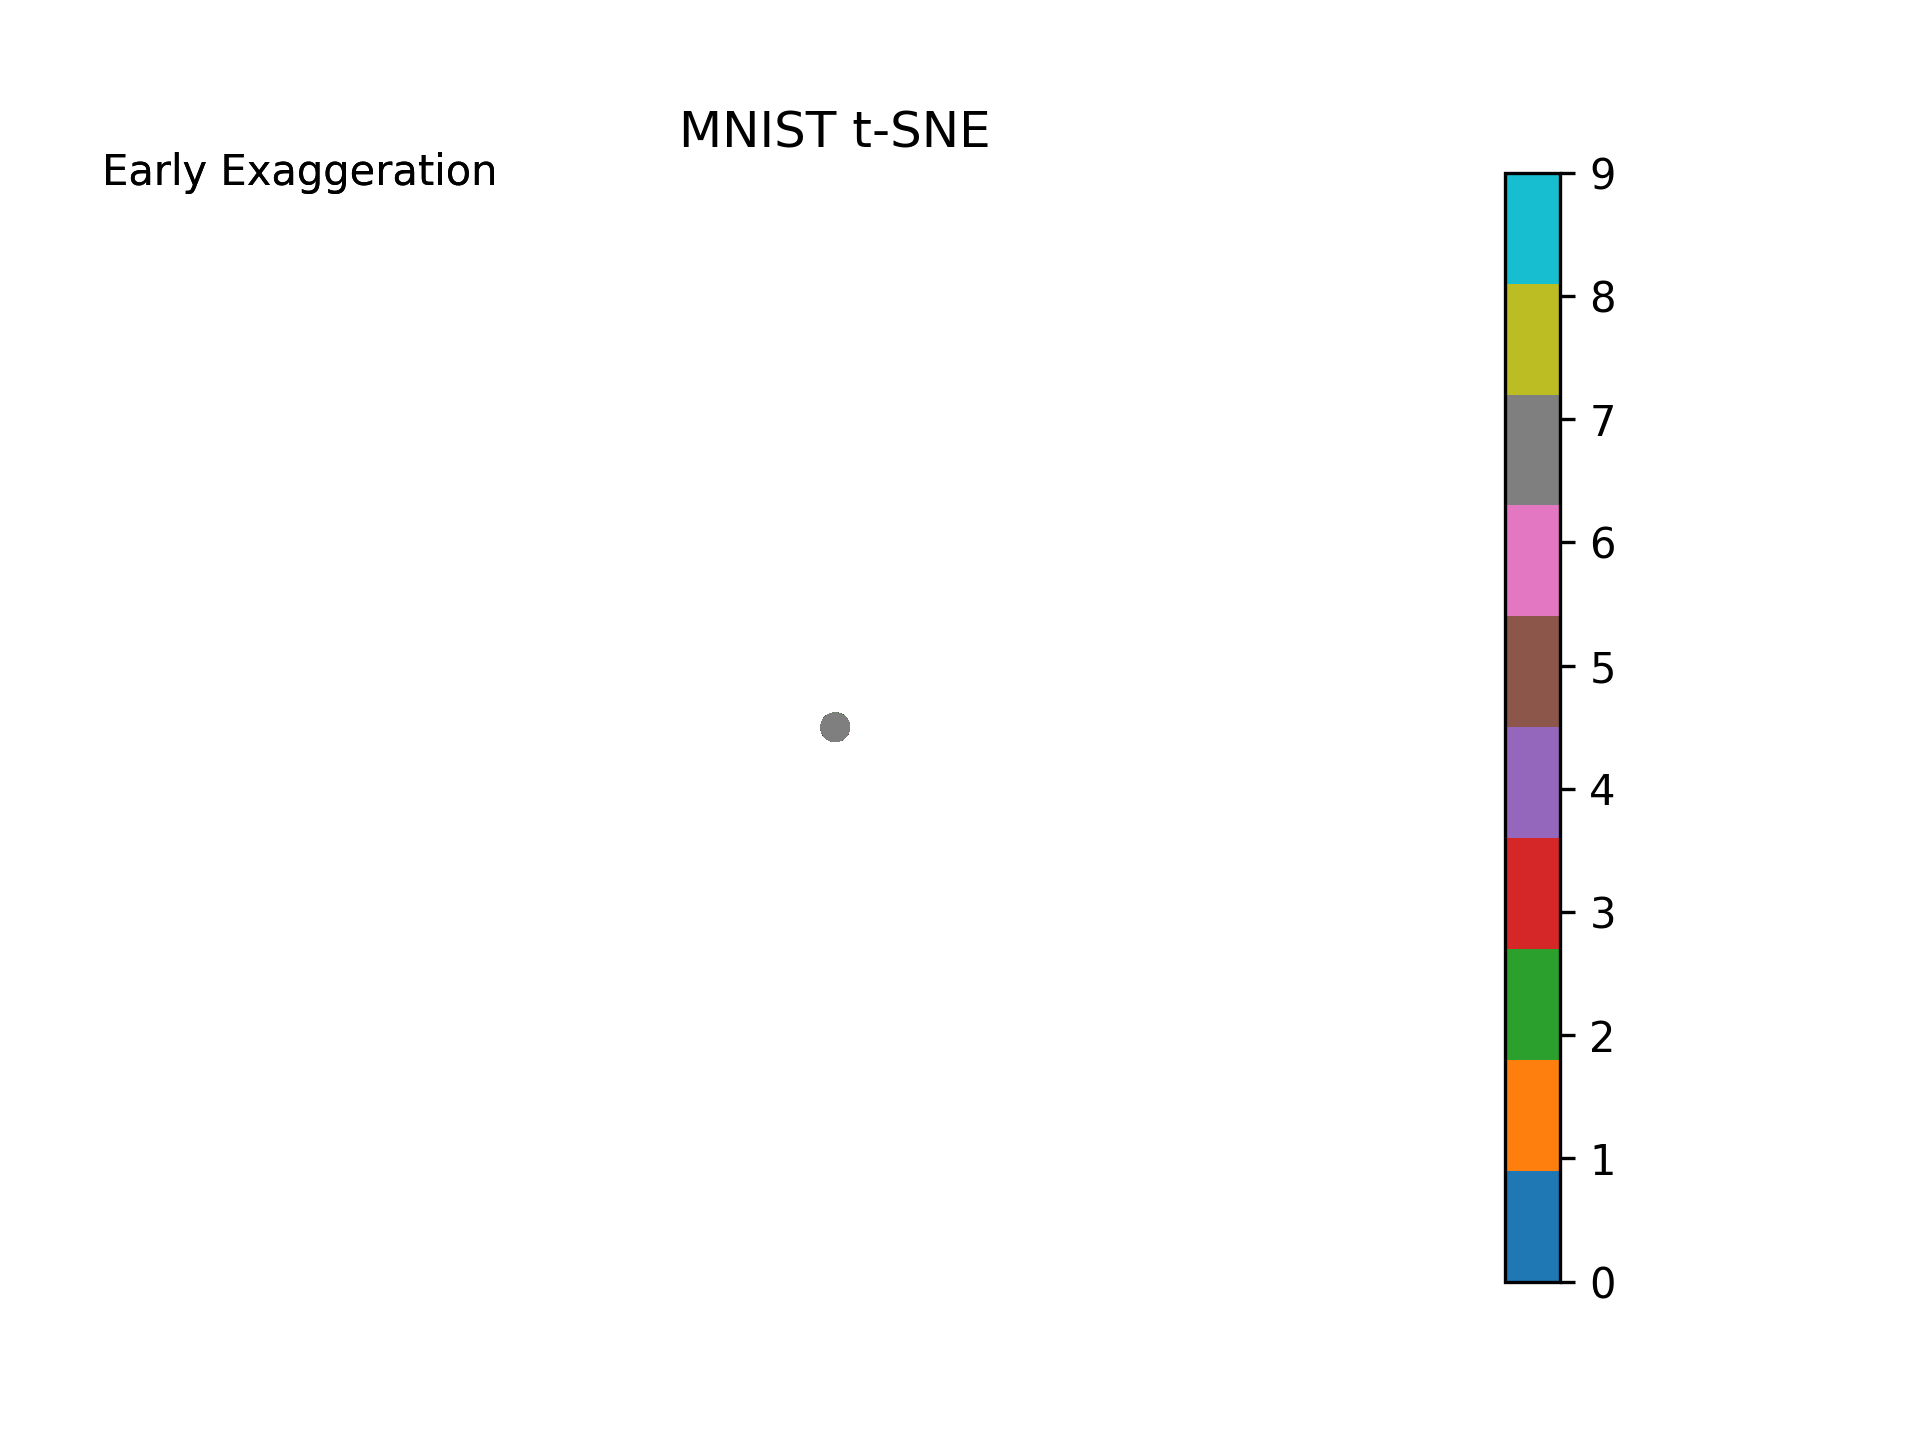

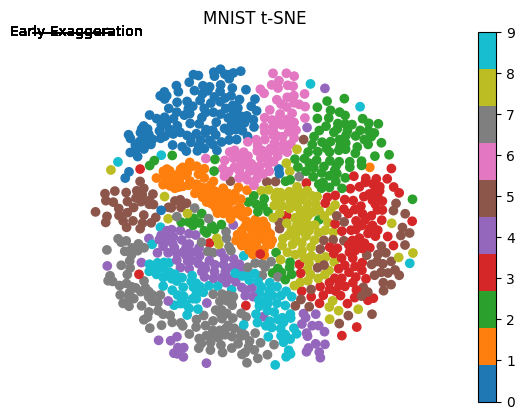

In [ ]:
def tsne_evolution_fig():
    fig, ax = plt.subplots()
    ax.axis("off")
    ax.set_title("MNIST t-SNE")
    scat = ax.scatter(Y[1][:, 0], Y[1][:, 1], c=y_reduced, cmap="tab10")
    plt.colorbar(scat, ax=ax)

    # t-SNE Descent Animation
    ys = []
    prelims = list(range(0, 50, 5))
    early_range = list(range(50, 250, 10))
    mid_range_1 = list(range(250, 300, 5))
    mid_range_2 = list(range(300, 400, 10))
    end_range = list(range(400, 1000, 50))

    visual_range = (
        prelims
        + early_range
        + mid_range_1
        + mid_range_2
        + end_range
        + [999, 999, 999, 999, 999, 999, 999]
    )

    for i in visual_range:
        ys.append(Y[i])

    def strike(text):
        result = ""
        for c in text:
            result = result + c + "\u0336"
        return result

    def animate(iterations):
        scat.set_offsets(ys[iterations])
        if iterations < 31:
            ax.text(
                0.05,
                1,
                "Early Exaggeration",
                horizontalalignment="center",
                verticalalignment="center",
                transform=ax.transAxes,
            )
        else:
            ax.text(
                0.05,
                1,
                strike("                  "),
                horizontalalignment="center",
                verticalalignment="center",
                transform=ax.transAxes,
            )

        ax.set_xlim(
            [
                1.25 * np.min(ys[iterations][:, 0]),
                1.25 * np.max(ys[iterations][:, 0]),
            ]
        )
        ax.set_ylim(
            [
                1.25 * np.min(ys[iterations][:, 1]),
                1.25 * np.max(ys[iterations][:, 1]),
            ]
        )

    rot_animation = animation.FuncAnimation(
        fig, animate, frames=len(ys) - 1, interval=350, blit=False
    )

    rot_animation.save("./MNIST.gif", dpi=300)


tsne_evolution_fig()
mo.image("./MNIST.gif", height=500).center()

I recommend playing around with different values of the parameters (i.e., perplexity, learning rate, early exaggeration, etc.) to see how the solution differs (See the original paper and the scikit-learn documentation for guides on using these parameters).

## References

[1] van der Maaten, L.J.P.; Hinton, G.E. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research 9:2579–2605, 2008.

[2] LeCun et al. (1999): The MNIST Dataset Of Handwritten Digits (Images)